# Masked Autoencoders para Reconstrução de Dados Sísmicos 3D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import seaborn as sns
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# 1. Introdução e Fundamentos Teóricos

## 1.1 Contexto do Trabalho

Este trabalho investiga a aplicação de Masked Autoencoders (MAE) para reconstrução de dados sísmicos 3D.
Dados sísmicos frequentemente apresentam problemas de aquisição, resultando em gaps ou dados faltantes
que comprometem a interpretação geológica. Métodos tradicionais de interpolação possuem limitações
em preservar estruturas complexas, motivando a exploração de abordagens baseadas em deep learning.

## 1.2 Masked Autoencoders (MAE)

Os Masked Autoencoders (He et al., 2021) são uma arquitetura de aprendizado auto-supervisionado que opera
mascarando uma alta porcentagem (ex: 75%) dos dados de entrada e aprendendo a reconstruí-los a partir
das partes visíveis.

### Princípio de Funcionamento:

1. **Mascaramento Aleatório**: Remoção de patches aleatórios dos dados de entrada
2. **Encoder**: Processa apenas as partes visíveis (não mascaradas)
3. **Decoder**: Reconstrói os dados completos a partir da representação latente
4. **Objetivo**: Minimizar a diferença entre a reconstrução e os dados originais

### Vantagens para Processamento de Dados:

- Aprendizado de representações ricas sem necessidade de labels
- Robustez a dados faltantes (naturalmente lida com missing data)
- Eficiência computacional (encoder processa apenas partes visíveis)
- Capacidade de generalização para diferentes padrões de mascaramento

## Demonstração Prática: MAE para Imagens 2D


Preparando e treinando MAE 2D (versão simplificada)...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.1279
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0118
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.0042
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0025
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0018


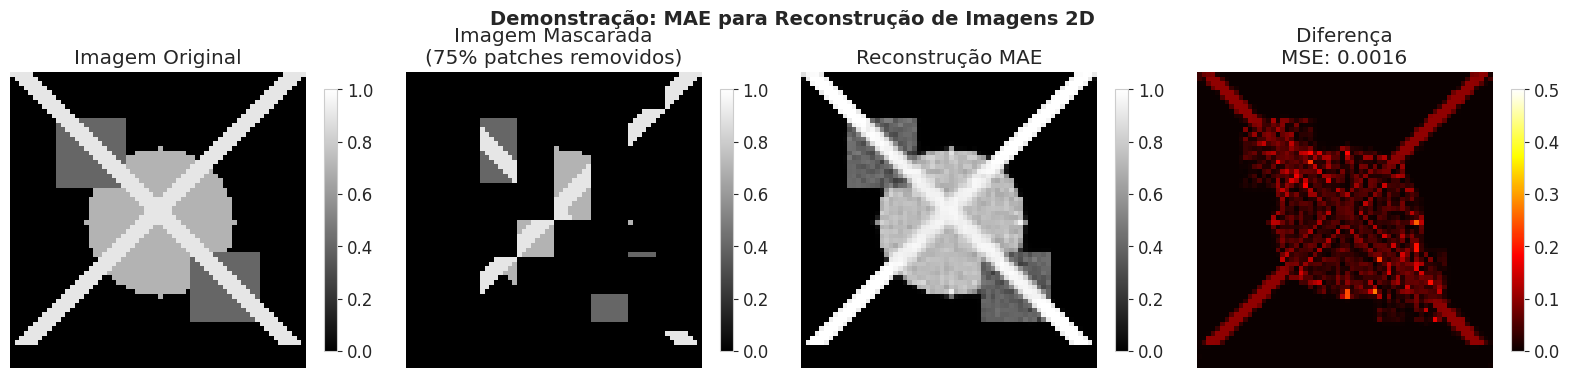


RESULTADOS DA DEMONSTRAÇÃO 2D
Patches visíveis: 25.0%
Patches mascarados: 75.0%
MSE da reconstrução: 0.001604
PSNR: 27.95 dB


In [ ]:
def create_sample_image(size=64):
    """Cria uma imagem com padrões geométricos para demonstração do MAE"""
    img = np.zeros((size, size))

    # Adicionar formas geométricas

    ## Círculo central
    center = size // 2
    radius = size // 4
    for i in range(size):
        for j in range(size):
            if (i - center)**2 + (j - center)**2 <= radius**2:
                img[i, j] = 0.7

    ## Retângulo superior esquerdo
    img[10:25, 10:25] = 0.4

    ## Retângulo inferior direito
    img[size-25:size-10, size-25:size-10] = 0.4

    ## Linha diagonal
    for i in range(size):
        if 0 <= i < size-5:
            img[i, i:i+5] = 0.9

    ## Linha anti-diagonal
    for i in range(size):
        if 0 <= i < size-5:
            img[i, size-i-5:size-i] = 0.9

    return img

original_image = create_sample_image(64)

def create_patch_mask(image, patch_size=8, mask_ratio=0.75):
    """
    Cria máscara no estilo MAE: divide a imagem em patches e mascara uma porcentagem

    Args:
        image: Imagem de entrada (H, W)
        patch_size: Tamanho dos patches quadrados
        mask_ratio: Proporção de patches a serem mascarados

    Returns:
        Tuple: (masked_image, mask, visible_patches)
    """
    H, W = image.shape
    n_patches_h = H // patch_size
    n_patches_w = W // patch_size

    # Criar máscara de patches
    patch_mask = np.ones((n_patches_h, n_patches_w), dtype=bool)
    total_patches = n_patches_h * n_patches_w
    n_masked_patches = int(total_patches * mask_ratio)

    # Selecionar patches aleatórios para mascarar
    masked_indices = np.random.choice(total_patches, n_masked_patches, replace=False)

    for idx in masked_indices:
        i = idx // n_patches_w
        j = idx % n_patches_w
        patch_mask[i, j] = False

    # Expandir máscara para nível de pixel
    mask = np.repeat(np.repeat(patch_mask, patch_size, axis=0), patch_size, axis=1)

    # Garantir que a máscara tenha o mesmo tamanho da imagem
    mask = mask[:H, :W]

    # Aplicar máscara
    masked_image = image.copy()
    masked_image[~mask] = 0

    return masked_image, mask, patch_mask

# Aplicar mascaramento
masked_image, pixel_mask, patch_mask = create_patch_mask(original_image, patch_size=8, mask_ratio=0.75)

def build_simple_mae_2d(input_shape=(64, 64, 1), latent_dim=128):
    """Constrói um MAE simples para demonstração em 2D"""

    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Processar patches visíveis (simulação simplificada)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    # Latent space
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(16*16*64, activation='relu')(latent)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    return model

# Preparar dados e treinar modelo simplificado
## Para demonstração, usaremos uma abordagem mais simples
## Criar múltiplas cópias da imagem com diferentes mascaramentos
n_samples = 100
images = []
masked_images = []

for _ in range(n_samples):
    img = create_sample_image(64)
    masked_img, _, _ = create_patch_mask(img, patch_size=8, mask_ratio=0.75)
    images.append(img)
    masked_images.append(masked_img)

# Converter para arrays numpy
X_train = np.array(masked_images)[..., np.newaxis]  # Adicionar dimensão do canal
y_train = np.array(images)[..., np.newaxis]

# Criar e treinar modelo
simple_mae = build_simple_mae_2d()
simple_mae.compile(optimizer='adam', loss='mse')

# Treinar por poucas épocas para demonstração
simple_mae.fit(X_train, y_train, epochs=5, batch_size=8, verbose=1)

# Testar reconstrução
test_masked = masked_image[np.newaxis, ..., np.newaxis]
reconstructed = simple_mae.predict(test_masked, verbose=0)[0, ..., 0]

# Visualizar resultados
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Imagem original
im1 = axes[0].imshow(original_image, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Imagem Original')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

# Imagem mascarada
im2 = axes[1].imshow(masked_image, cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f'Imagem Mascarada\n(75% patches removidos)')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], shrink=0.8)

# Reconstrução
im3 = axes[2].imshow(reconstructed, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Reconstrução MAE')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], shrink=0.8)

# Diferença
diff = np.abs(original_image - reconstructed)
im4 = axes[3].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
axes[3].set_title(f'Diferença\nMSE: {np.mean(diff**2):.4f}')
axes[3].axis('off')
plt.colorbar(im4, ax=axes[3], shrink=0.8)

plt.suptitle('Demonstração: MAE para Reconstrução de Imagens 2D', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Métricas quantitativas
mse = np.mean((original_image - reconstructed) ** 2)
psnr = 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else float('inf')
visible_ratio = pixel_mask.sum() / pixel_mask.size

print("\n" + "="*70)
print("RESULTADOS DA DEMONSTRAÇÃO 2D")
print("="*70)
print(f"Patches visíveis: {visible_ratio*100:.1f}%")
print(f"Patches mascarados: {(1-visible_ratio)*100:.1f}%")
print(f"MSE da reconstrução: {mse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print("="*70)

Explicação da celula acima

## Extensão do MAE para Dados 3D

## 3.1 Justificativa da Extensão

A extensão de arquiteturas 2D para 3D é fundamental para dados sísmicos devido à:

1. **Natureza Tridimensional**: Dados sísmicos são adquiridos como volumes 3D (inline, crossline, tempo)
2. **Correlações Espaciais**: Estruturas geológicas exibem continuidade nas três direções
3. **Informação Contextual**: A interpretação requer compreensão das relações 3D

## 3.2 Adaptações Necessárias

### 3.2.1 Operações Convolucionais 3D
- Substituir Conv2D por Conv3D
- Substituir MaxPooling2D por MaxPooling3D
- Operações de upsampling adaptadas para 3D

### 3.2.2 Mascaramento 3D
- Patches cúbicos em vez de retangulares
- Consideração de vizinhança nas três dimensões
- Padrões de mascaramento que respeitem a estrutura 3D

### 3.2.3 Complexidade Computacional
- Maior número de parâmetros
- Requisitos de memória aumentados
- Tempo de treinamento mais longo

## 3.3 Arquitetura Proposta

Para dados sísmicos 3D, propomos uma arquitetura baseada em:
```
          {Input [H×W×D×1]}
                ↓
{Mascaramento 3D (75% patches removidos)}
                ↓
   {Encoder (Conv3D + Pooling)}
                ↓
  {Latent Space [dimensão reduzida]}
                ↓
    {Decoder (Conv3DTranspose)}
                ↓
      {Reconstruction [H×W×D×1]}
```

Algo mais similar o que faremos é:
```
        {Input [32×32×32×1]}
                     ↓
   {Mascaramento 3D (patches ocultados)}
                     ↓
     {Encoder 3D (Conv3D + Strides=2)}
   32³ → 16³ → 8³ → 4³   (canais: 16 → 32 → 64)
                     ↓
     {Latent Space [vetor de 256 dimensões]}
                     ↓
   {Decoder 3D (Dense + Conv3DTranspose)}
      4³ → 8³ → 16³ → 32³   (canais: 64 → 32 → 16)
                     ↓
         {Reconstrução [32×32×32×1]}

```

## 3.4 Vantagens para Dados Sísmicos

1. **Preservação de Estruturas 3D**: Captura padrões geológicos complexos
2. **Robustez a Gaps de Aquisição**: Lida naturalmente com dados faltantes e gaps evitando a necessidade de coletar novamente
3. **Aprendizado de Features Hierárquicas**: Extrai features em múltiplas escalas
4. **Generalização**: Aprende representações úteis para diversas tarefas como reconhecimento


## Geração de Dados Sísmicos Sintéticos 3D


GERAÇÃO DE DADOS SÍSMICOS SINTÉTICOS 3D

Gerando volume sísmico sintético 3D...
Volume gerado: (64, 64, 64)
Valores: min=0.0000, max=1.0000
Estatísticas: média=0.1635, std=0.1295


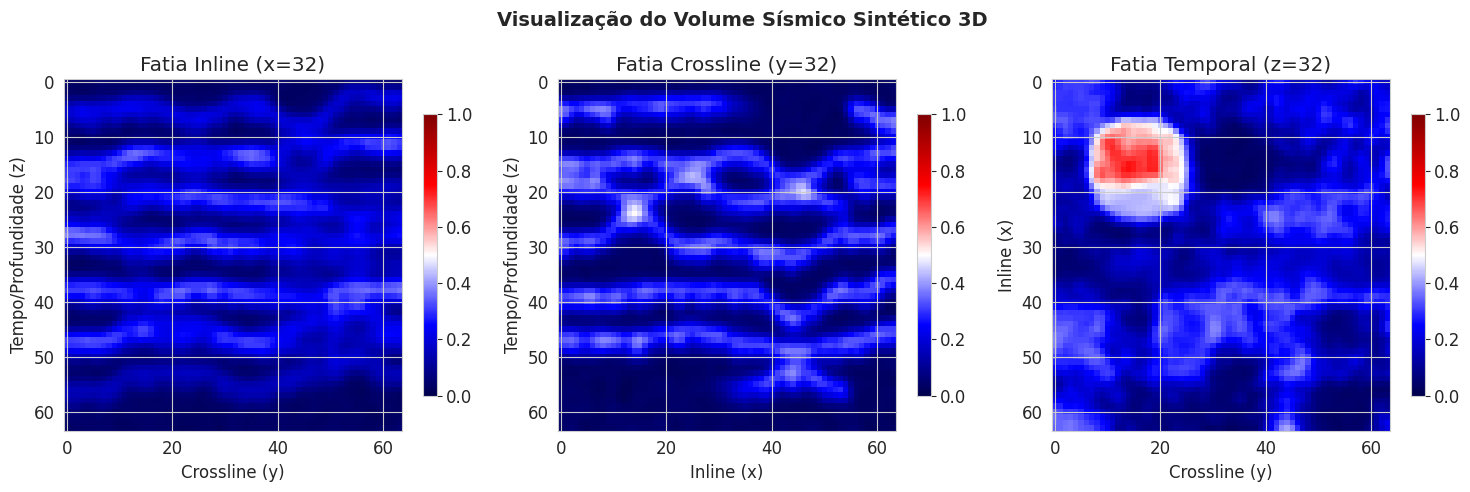

In [ ]:
def generate_3d_seismic_data(shape=(64, 64, 64)):
    """
    Gera volume sísmico sintético 3D com características realistas.

    Args:
        shape: Dimensões do volume (inline, crossline, tempo/profundidade)

    Returns:
        Array numpy 3D com dados sísmicos sintéticos
    """
    nx, ny, nz = shape
    data = np.zeros(shape)

    # Adicionar ruído de fundo (baixa amplitude)
    data = np.random.normal(0, 0.05, shape)

    # Adicionar horizontes (camadas estratigráficas)
    n_horizons = 6
    for h in range(n_horizons):
        base_depth = 5 + h * 8

        # Adicionar variação espacial aos horizontes
        depth_variation = np.zeros((nx, ny))
        for i in range(0, nx, 10):
            for j in range(0, ny, 10):
                depth_variation[i:i+10, j:j+10] = base_depth + np.random.randn() * 2

        # Suavizar as transições
        depth_variation = gaussian_filter(depth_variation, sigma=2)

        for i in range(nx):
            for j in range(ny):
                depth = int(depth_variation[i, j])
                thickness = np.random.randint(2, 6)

                # Garantir limites
                start = max(0, min(depth, nz-1))
                end = max(0, min(depth + thickness, nz-1))

                # Adicionar reflexão sísmica
                if start < end:
                    amplitude = 0.3 + np.random.rand() * 0.3
                    data[i, j, start:end] += amplitude

    # Adicionar falha geológica
    fault_position = nx // 2 + np.random.randint(-5, 5)
    fault_throw = np.random.randint(8, 15)

    # Aplicar falha com transição suave
    for i in range(fault_position, nx):
        blend = (i - fault_position) / 10.0
        blend = min(1.0, max(0.0, blend))

        if i < nx - fault_throw:
            # Misturar original com deslocado
            original_slice = data[i, :, :].copy()
            shifted_slice = np.roll(data[i, :, :], fault_throw, axis=1)
            data[i, :, :] = (1 - blend) * original_slice + blend * shifted_slice

    # Adicionar corpo de sal (anomalia de alta velocidade)
    if nx > 40 and ny > 40:
        salt_center_x = nx // 4
        salt_center_y = ny // 4
        salt_radius = min(nx, ny) // 6

        for i in range(nx):
            for j in range(ny):
                distance = np.sqrt((i - salt_center_x)**2 + (j - salt_center_y)**2)
                if distance <= salt_radius:
                    salt_top = 15
                    salt_bottom = 40
                    if salt_top < nz and salt_bottom < nz:
                        data[i, j, salt_top:salt_bottom] += 0.5

    # Suavizar para aparência mais realista
    data = gaussian_filter(data, sigma=1.0)

    # Normalizar para intervalo [0, 1]
    data_min = data.min()
    data_max = data.max()
    if data_max > data_min:
        data = (data - data_min) / (data_max - data_min)

    return data

print("\nGerando volume sísmico sintético 3D...")
seismic_volume = generate_3d_seismic_data(shape=(64, 64, 64))
print(f"-> Volume gerado: {seismic_volume.shape}")
print(f"-> Valores: min={seismic_volume.min():.4f}, max={seismic_volume.max():.4f}")
print(f"-> Estatísticas: média={seismic_volume.mean():.4f}, std={seismic_volume.std():.4f}")

# Visualizar fatias do volume
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Fatia inline (x constante)
slice_inline = seismic_volume[32, :, :]
im1 = axes[0].imshow(slice_inline.T, aspect='auto', cmap='seismic',
                     vmin=seismic_volume.min(), vmax=seismic_volume.max())
axes[0].set_title('Fatia Inline (x=32)')
axes[0].set_xlabel('Crossline (y)')
axes[0].set_ylabel('Tempo/Profundidade (z)')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

# Fatia crossline (y constante)
slice_crossline = seismic_volume[:, 32, :]
im2 = axes[1].imshow(slice_crossline.T, aspect='auto', cmap='seismic',
                     vmin=seismic_volume.min(), vmax=seismic_volume.max())
axes[1].set_title('Fatia Crossline (y=32)')
axes[1].set_xlabel('Inline (x)')
axes[1].set_ylabel('Tempo/Profundidade (z)')
plt.colorbar(im2, ax=axes[1], shrink=0.8)

# Fatia temporal (z constante)
slice_time = seismic_volume[:, :, 32]
im3 = axes[2].imshow(slice_time, aspect='auto', cmap='seismic',
                     vmin=seismic_volume.min(), vmax=seismic_volume.max())
axes[2].set_title('Fatia Temporal (z=32)')
axes[2].set_xlabel('Crossline (y)')
axes[2].set_ylabel('Inline (x)')
plt.colorbar(im3, ax=axes[2], shrink=0.8)

plt.suptitle('Visualização do Volume Sísmico Sintético 3D', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Implementação do MAE 3D para Dados Sísmicos


IMPLEMENTAÇÃO DO MAE 3D PARA DADOS SÍSMICOS

Preparando dados para treinamento do MAE 3D...
Patches de treinamento: (500, 32, 32, 32, 1)
Patches originais: (500, 32, 32, 32, 1)
Treino: 400 patches
Validação: 100 patches

Construindo arquitetura MAE 3D...
Resumo da arquitetura:


Model: "MAE_3D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 32, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 16, 16, 16, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 16, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 16, 16, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 8, 8, 8, 32)    │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 8, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 8, 8, 8, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 4, 4, 4, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 4, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 4, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_3              │ (None, 8, 8, 8, 64)    │       110,656 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 8, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_4              │ (None, 16, 16, 16, 32) │        55,328 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 16, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_5              │ (None, 32, 32, 32, 16) │        13,840 │
│ (Conv3DTranspose)               │                        │             

 Total params: 2,352,321 (8.97 MB)

 Trainable params: 2,351,873 (8.97 MB)

 Non-trainable params: 448 (1.75 KB)


Treinando MAE 3D (pode levar alguns minutos)...
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - loss: 0.0390 - mae: 0.1469 - val_loss: 0.0258 - val_mae: 0.1327 - learning_rate: 0.0010
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - loss: 0.0161 - mae: 0.1013 - val_loss: 0.0343 - val_mae: 0.1383 - learning_rate: 0.0010
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - loss: 0.0146 - mae: 0.0977 - val_loss: 0.0474 - val_mae: 0.1725 - learning_rate: 0.0010
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0132 - mae: 0.0942
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.0132 - mae: 0.0942 - val_loss: 0.0389 - val_mae: 0.1500 - learning_rate: 0.0010
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 0.0120 - mae: 0.0908 - val_loss: 0.0257 - val_mae: 0.1180 - learning_rate: 5.0000e-04
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 0.0114 - mae: 0.0887 - val

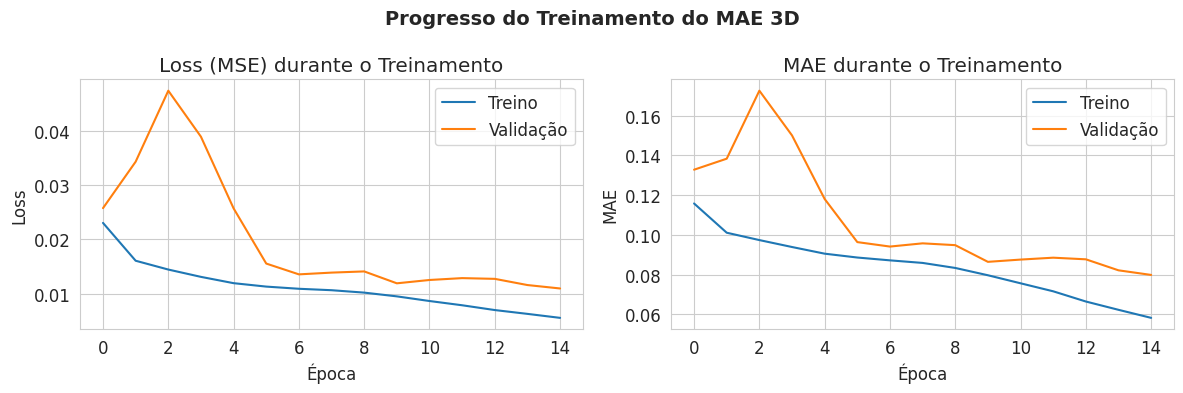

In [ ]:
# Funções de mascaramento 3D
def create_3d_patch_mask(volume_shape, patch_size=8, mask_ratio=0.75):
    """
    Cria máscara 3D no estilo MAE para volume sísmico.

    Args:
        volume_shape: Forma do volume 3D (nx, ny, nz)
        patch_size: Tamanho dos patches cúbicos
        mask_ratio: Proporção de patches a serem mascarados

    Returns:
        Tuple: (masked_volume, mask)
    """
    nx, ny, nz = volume_shape
    n_patches_x = nx // patch_size
    n_patches_y = ny // patch_size
    n_patches_z = nz // patch_size

    # Criar máscara de patches
    patch_mask = np.ones((n_patches_x, n_patches_y, n_patches_z), dtype=bool)
    total_patches = n_patches_x * n_patches_y * n_patches_z
    n_masked_patches = int(total_patches * mask_ratio)

    # Selecionar patches aleatórios para mascarar
    masked_indices = np.random.choice(total_patches, n_masked_patches, replace=False)

    for idx in masked_indices:
        i = idx // (n_patches_y * n_patches_z)
        j = (idx // n_patches_z) % n_patches_y
        k = idx % n_patches_z
        patch_mask[i, j, k] = False

    # Expandir máscara para nível de voxel
    mask = np.repeat(np.repeat(np.repeat(patch_mask,
                                        patch_size, axis=0),
                              patch_size, axis=1),
                    patch_size, axis=2)

    # Garantir que a máscara tenha o mesmo tamanho do volume
    mask = mask[:nx, :ny, :nz]

    return mask

def apply_3d_mask(volume, mask):
    """Aplica máscara 3D ao volume"""
    masked_volume = volume.copy()
    masked_volume[~mask] = 0
    return masked_volume

# 5.2 Arquitetura do MAE 3D
def build_mae_3d(input_shape=(32, 32, 32, 1), latent_dim=256):
    """
    Constrói arquitetura MAE 3D para dados sísmicos.

    Args:
        input_shape: Forma dos patches de entrada
        latent_dim: Dimensão do espaço latente

    Returns:
        Modelo Keras do MAE 3D
    """

    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Bloco 1: Downsampling 32x32x32 -> 16x16x16
    x = layers.Conv3D(16, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloco 2: Downsampling 16x16x16 -> 8x8x8
    x = layers.Conv3D(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloco 3: Downsampling 8x8x8 -> 4x4x4
    x = layers.Conv3D(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Representação latente
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    # Reconstruir para forma 4x4x4x64
    x = layers.Dense(4*4*4*64, activation='relu')(latent)
    x = layers.Reshape((4, 4, 4, 64))(x)

    # Bloco 1: Upsampling 4x4x4x64 -> 8x8x8x64
    x = layers.Conv3DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloco 2: Upsampling 8x8x8x64 -> 16x16x16x32
    x = layers.Conv3DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bloco 3: Upsampling 16x16x16x32 -> 32x32x32x16
    x = layers.Conv3DTranspose(16, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Camada de saída: 32x32x32x1
    outputs = layers.Conv3D(1, 3, activation='sigmoid', padding='same')(x)

    # Criar modelo
    model = Model(inputs, outputs, name='MAE_3D')

    return model

# Preparação dos dados para treinamento
def prepare_3d_training_data(volume, patch_size=32, n_patches=1000, mask_ratio=0.75):
    """
    Prepara patches para treinamento do MAE 3D.

    Args:
        volume: Volume sísmico completo
        patch_size: Tamanho dos patches cúbicos
        n_patches: Número de patches a gerar
        mask_ratio: Proporção de mascaramento

    Returns:
        Tupla (patches_mascarados, patches_originais)
    """

    patches_masked = []
    patches_original = []

    nx, ny, nz = volume.shape

    for _ in range(n_patches):
        # Selecionar posição aleatória
        x = np.random.randint(0, nx - patch_size)
        y = np.random.randint(0, ny - patch_size)
        z = np.random.randint(0, nz - patch_size)

        # Extrair patch
        patch = volume[x:x+patch_size, y:y+patch_size, z:z+patch_size]

        # Criar máscara para o patch
        mask = create_3d_patch_mask((patch_size, patch_size, patch_size),
                                   patch_size=8, mask_ratio=mask_ratio)

        # Aplicar máscara
        masked_patch = apply_3d_mask(patch, mask)

        patches_masked.append(masked_patch)
        patches_original.append(patch)

    # Converter para arrays
    patches_masked = np.array(patches_masked)[..., np.newaxis]
    patches_original = np.array(patches_original)[..., np.newaxis]

    return patches_masked, patches_original

# Preparar e treinar o MAE 3D
print("\nPreparando dados para treinamento do MAE 3D...")

# Preparar patches de treinamento
X_masked, X_original = prepare_3d_training_data(
    seismic_volume,
    patch_size=32,
    n_patches=500,  # Reduzido para demonstração
    mask_ratio=0.75
)

print(f"Patches de treinamento: {X_masked.shape}")
print(f"Patches originais: {X_original.shape}")

# Dividir em treino e validação
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_masked, X_original, test_size=0.2, random_state=42
)

print(f"Treino: {X_train.shape[0]} patches")
print(f"Validação: {X_val.shape[0]} patches")

# Construir modelo
print("\nConstruindo arquitetura MAE 3D...")
mae_3d_model = build_mae_3d(input_shape=(32, 32, 32, 1), latent_dim=256)

# Compilar modelo
mae_3d_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("Resumo da arquitetura:")
mae_3d_model.summary()

# Treinar modelo
print("\nTreinando MAE 3D (pode levar alguns minutos)...")

# Callbacks para melhor treinamento
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Treinamento
history = mae_3d_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=4,  # Batch pequeno devido à memória 3D
    epochs=15,     # Reduzido para demonstração
    callbacks=callbacks,
    verbose=1
)

print("Treinamento concluído.")

# Visualizar progresso do treinamento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Treino')
axes[0].plot(history.history['val_loss'], label='Validação')
axes[0].set_title('Loss (MSE) durante o Treinamento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['mae'], label='Treino')
axes[1].plot(history.history['val_mae'], label='Validação')
axes[1].set_title('MAE durante o Treinamento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Progresso do Treinamento do MAE 3D', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Métodos Tradicionais de Interpolação

In [ ]:
# Implementação de métodos tradicionais
def nearest_neighbor_interpolation_3d(masked_data, mask):
    """
    Interpolação por vizinho mais próximo em 3D.

    Args:
        masked_data: Dados com valores faltantes
        mask: Máscara booleana (True = dados presentes)

    Returns:
        Dados interpolados
    """
    from scipy import ndimage

    # Encontrar distância até o vizinho mais próximo com dados
    distances, indices = ndimage.distance_transform_edt(
        ~mask,
        return_distances=True,
        return_indices=True
    )

    # Criar cópia para interpolação
    interpolated = masked_data.copy()

    # Para cada voxel sem dados, usar valor do vizinho mais próximo com dados
    for i in range(masked_data.shape[0]):
        for j in range(masked_data.shape[1]):
            for k in range(masked_data.shape[2]):
                if not mask[i, j, k]:
                    # Coordenadas do vizinho mais próximo com dados
                    ni, nj, nk = indices[0][i, j, k], indices[1][i, j, k], indices[2][i, j, k]
                    interpolated[i, j, k] = masked_data[ni, nj, nk]

    return interpolated

def linear_interpolation_3d(masked_data, mask):
    """
    Interpolação linear 3D simplificada.

    Nota: Implementação completa de interpolação linear 3D é complexa.
    Esta é uma versão simplificada para demonstração.

    Args:
        masked_data: Dados com valores faltantes
        mask: Máscara booleana

    Returns:
        Dados interpolados
    """
    interpolated = masked_data.copy()

    # Para cada direção, aplicar interpolação linear 1D
    # Esta é uma aproximação simplificada
    for i in range(masked_data.shape[0]):
        for j in range(masked_data.shape[1]):
            # Interpolar ao longo do eixo z
            slice_1d = masked_data[i, j, :]
            mask_1d = mask[i, j, :]

            # Encontrar índices com dados
            known_indices = np.where(mask_1d)[0]

            if len(known_indices) > 1:
                # Interpolar valores desconhecidos
                unknown_indices = np.where(~mask_1d)[0]

                # Para cada ponto desconhecido, encontrar os dois pontos conhecidos mais próximos
                for idx in unknown_indices:
                    # Encontrar pontos conhecidos à esquerda e direita
                    left_idx = known_indices[known_indices < idx]
                    right_idx = known_indices[known_indices > idx]

                    if len(left_idx) > 0 and len(right_idx) > 0:
                        left_val = slice_1d[left_idx[-1]]
                        right_val = slice_1d[right_idx[0]]

                        # Distâncias
                        d_left = idx - left_idx[-1]
                        d_right = right_idx[0] - idx
                        d_total = d_left + d_right

                        # Interpolação linear ponderada
                        interpolated[i, j, idx] = (d_right/d_total) * left_val + (d_left/d_total) * right_val

    return interpolated

def calculate_metrics_3d(original, reconstructed, mask):
    """
    Calcula métricas de qualidade para reconstrução 3D.

    Args:
        original: Dados originais completos
        reconstructed: Dados reconstruídos
        mask: Máscara booleana (True = dados presentes no original)

    Returns:
        Dicionário com métricas
    """

    # Calcular erro apenas nas regiões originalmente mascaradas
    error_region = ~mask

    if error_region.sum() > 0:
        # Erro nas regiões interpoladas
        mse = np.mean((original[error_region] - reconstructed[error_region]) ** 2)
        mae = np.mean(np.abs(original[error_region] - reconstructed[error_region]))

        # SNR
        signal_power = np.mean(original[error_region] ** 2)
        noise_power = mse
        snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')

        # PSNR
        max_val = original.max()
        psnr = 20 * np.log10(max_val / np.sqrt(mse)) if mse > 0 else float('inf')
    else:
        mse = mae = snr = psnr = 0

    return {
        'MSE': mse,
        'MAE': mae,
        'SNR_dB': snr,
        'PSNR_dB': psnr
    }

## Comparação entre MAE e Métodos Tradicionais


COMPARAÇÃO: MAE 3D vs MÉTODOS TRADICIONAIS

Preparando cenário de teste...
Volume de teste: (32, 32, 32)
Porcentagem mascarada: 75.0%

1. Reconstrução com MAE 3D...
2. Interpolação por vizinho mais próximo...
3. Interpolação linear 3D...

RESULTADOS COMPARATIVOS
Método                    MSE          MAE          SNR (dB)     PSNR (dB)   
--------------------------------------------------------------------------------
MAE 3D                    0.008227     0.073657     9.44         20.82       
Nearest Neighbor          0.016698     0.091433     6.37         17.75       
Linear Interpolation      0.068949     0.217880     0.21         11.59       

Visualizando comparação qualitativa...


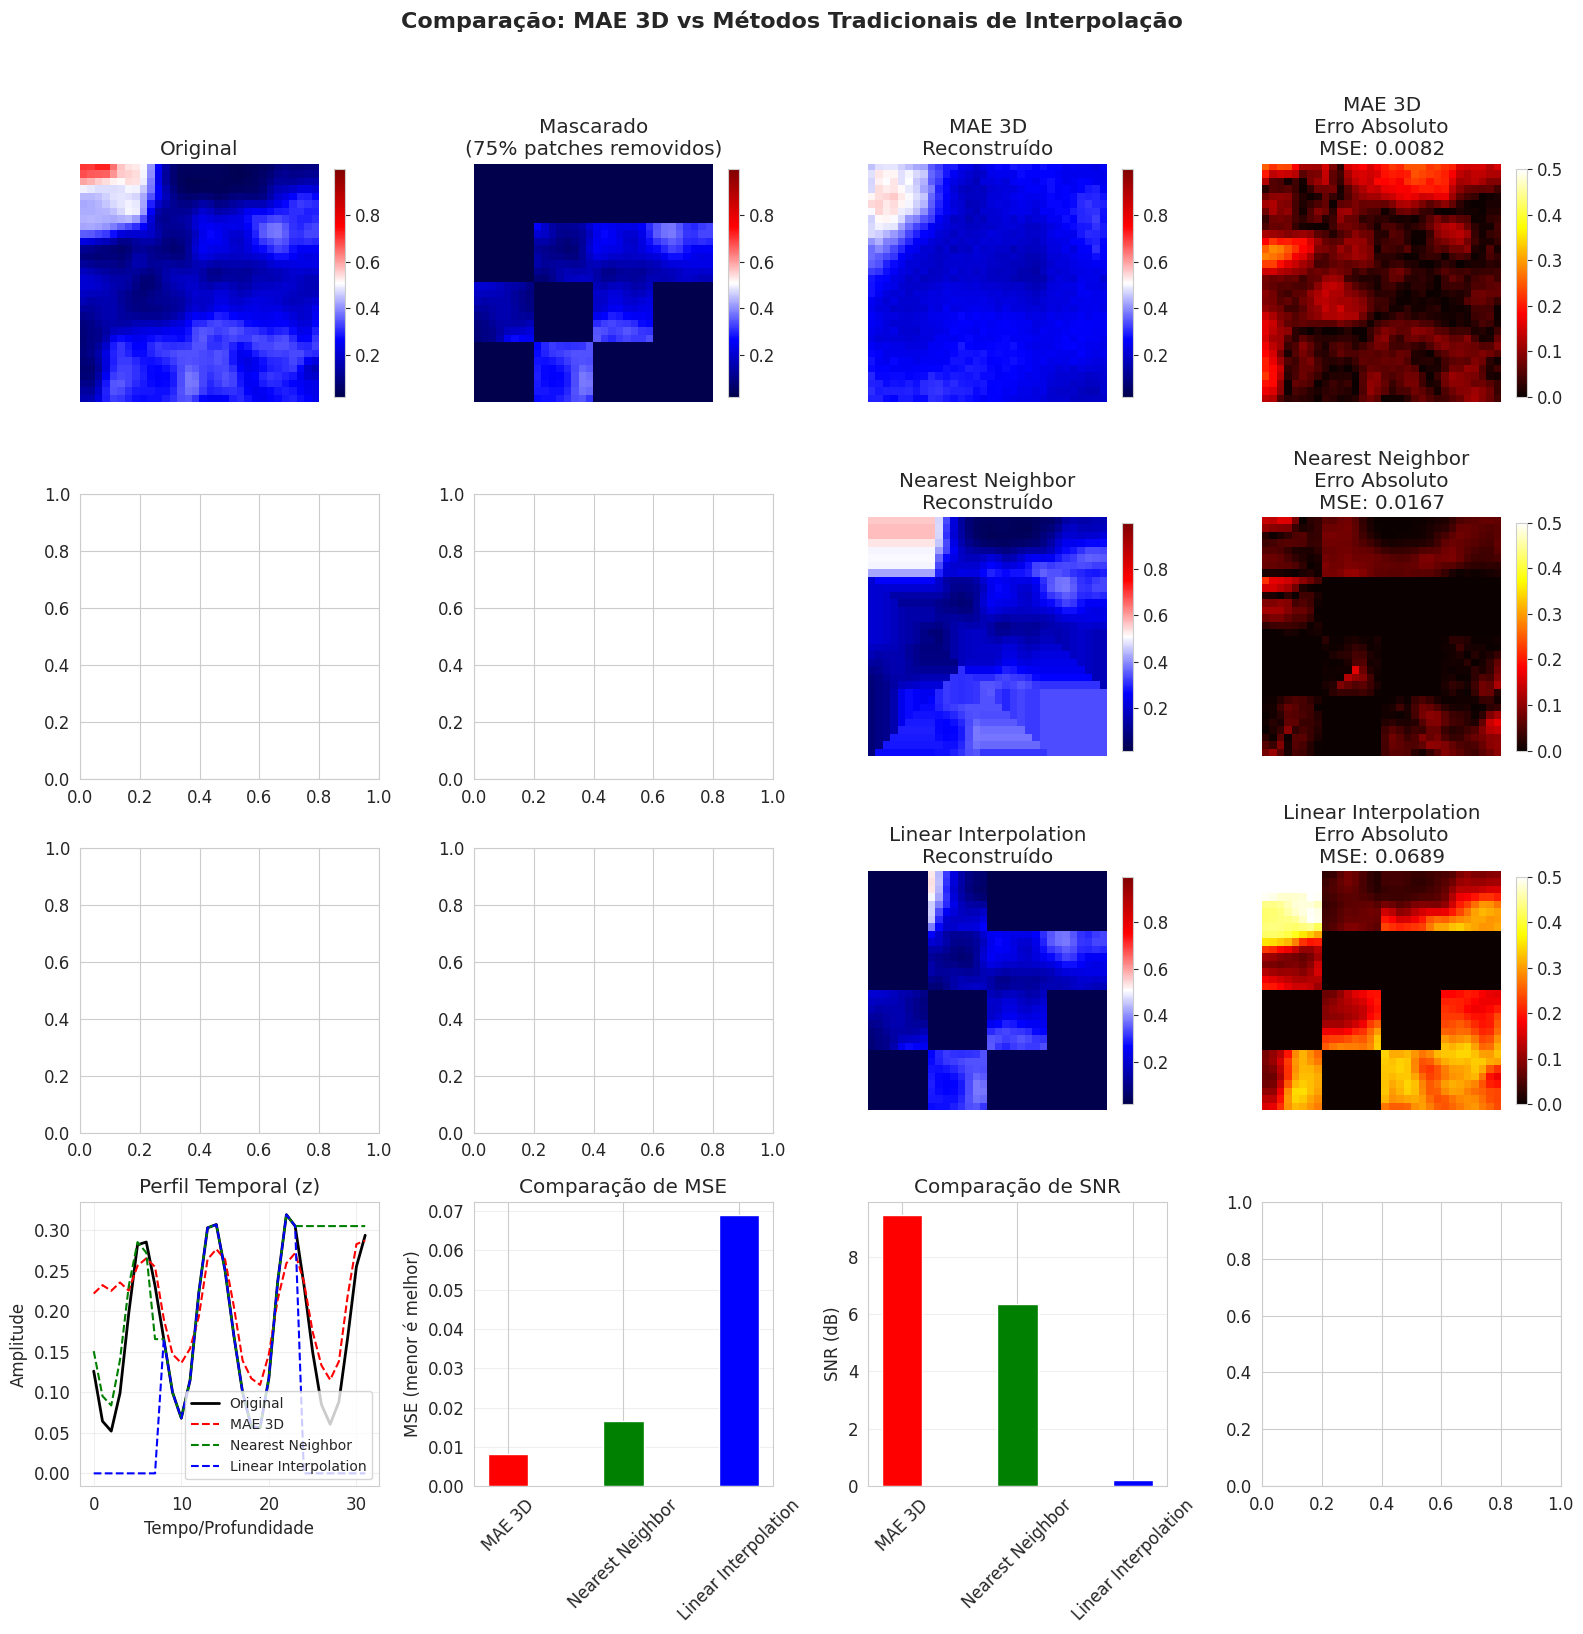

In [ ]:
# Preparar cenário de teste
# Selecionar subvolume para teste
test_volume = seismic_volume[16:48, 16:48, 16:48]  # 32x32x32
test_mask = create_3d_patch_mask(test_volume.shape, patch_size=8, mask_ratio=0.75)
test_masked = apply_3d_mask(test_volume, test_mask)

print(f"Volume de teste: {test_volume.shape}")
print(f"Porcentagem mascarada: {(1 - test_mask.sum() / test_mask.size) * 100:.1f}%")

# Aplicar diferentes métodos de reconstrução
results = {}

# Método 1: MAE 3D
print("\n1. Reconstrução com MAE 3D...")
mae_input = test_masked[np.newaxis, ..., np.newaxis]
mae_reconstructed = mae_3d_model.predict(mae_input, verbose=0)[0, ..., 0]
results['MAE 3D'] = {
    'reconstruction': mae_reconstructed,
    'metrics': calculate_metrics_3d(test_volume, mae_reconstructed, test_mask)
}

# Método 2: Vizinho mais próximo
print("2. Interpolação por vizinho mais próximo...")
nn_reconstructed = nearest_neighbor_interpolation_3d(test_masked, test_mask)
results['Nearest Neighbor'] = {
    'reconstruction': nn_reconstructed,
    'metrics': calculate_metrics_3d(test_volume, nn_reconstructed, test_mask)
}

# Método 3: Interpolação linear
print("3. Interpolação linear 3D...")
linear_reconstructed = linear_interpolation_3d(test_masked, test_mask)
results['Linear Interpolation'] = {
    'reconstruction': linear_reconstructed,
    'metrics': calculate_metrics_3d(test_volume, linear_reconstructed, test_mask)
}

# Exibir resultados comparativos
print("\n" + "="*80)
print("RESULTADOS COMPARATIVOS")
print("="*80)
print(f"{'Método':<25} {'MSE':<12} {'MAE':<12} {'SNR (dB)':<12} {'PSNR (dB)':<12}")
print("-"*80)

for method, result in results.items():
    metrics = result['metrics']
    print(f"{method:<25} {metrics['MSE']:<12.6f} {metrics['MAE']:<12.6f} "
          f"{metrics['SNR_dB']:<12.2f} {metrics['PSNR_dB']:<12.2f}")

print("="*80)

# Visualizar comparação qualitativa
print("\nVisualizando comparação qualitativa...")

# Selecionar fatia para visualização
slice_idx = 16  # Fatia do meio

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

methods = list(results.keys())

for row, method in enumerate(methods):
    result = results[method]
    reconstructed = result['reconstruction']

    # Original (apenas na primeira linha)
    if row == 0:
        im1 = axes[row, 0].imshow(test_volume[:, :, slice_idx], cmap='seismic',
                                  vmin=test_volume.min(), vmax=test_volume.max())
        axes[row, 0].set_title('Original')
        axes[row, 0].axis('off')
        plt.colorbar(im1, ax=axes[row, 0], shrink=0.8)

    # Mascarado (apenas na primeira linha)
    if row == 0:
        im2 = axes[row, 1].imshow(test_masked[:, :, slice_idx], cmap='seismic',
                                  vmin=test_volume.min(), vmax=test_volume.max())
        axes[row, 1].set_title(f'Mascarado\n(75% patches removidos)')
        axes[row, 1].axis('off')
        plt.colorbar(im2, ax=axes[row, 1], shrink=0.8)

    # Reconstruído
    im3 = axes[row, 2].imshow(reconstructed[:, :, slice_idx], cmap='seismic',
                              vmin=test_volume.min(), vmax=test_volume.max())
    axes[row, 2].set_title(f'{method}\nReconstruído')
    axes[row, 2].axis('off')
    plt.colorbar(im3, ax=axes[row, 2], shrink=0.8)

    # Erro absoluto
    error = np.abs(test_volume[:, :, slice_idx] - reconstructed[:, :, slice_idx])
    im4 = axes[row, 3].imshow(error, cmap='hot', vmin=0, vmax=0.5)
    axes[row, 3].set_title(f'{method}\nErro Absoluto\nMSE: {result["metrics"]["MSE"]:.4f}')
    axes[row, 3].axis('off')
    plt.colorbar(im4, ax=axes[row, 3], shrink=0.8)

# Linha adicional: Comparação de perfis
row = 3
x_pos, y_pos = 16, 16  # Posição central

# Perfil ao longo de z
axes[row, 0].plot(test_volume[x_pos, y_pos, :], 'k-', linewidth=2, label='Original')
for idx, method in enumerate(methods):
    color = ['r', 'g', 'b'][idx]
    reconstructed = results[method]['reconstruction']
    axes[row, 0].plot(reconstructed[x_pos, y_pos, :], '--', color=color,
                     linewidth=1.5, label=method)
axes[row, 0].set_title('Perfil Temporal (z)')
axes[row, 0].set_xlabel('Tempo/Profundidade')
axes[row, 0].set_ylabel('Amplitude')
axes[row, 0].legend(fontsize=10)
axes[row, 0].grid(True, alpha=0.3)

# Métricas comparativas em gráfico de barras
metrics_to_plot = ['MSE', 'SNR_dB']
x = np.arange(len(methods))
width = 0.35

for col, metric in enumerate(metrics_to_plot, 1):
    metric_values = [results[method]['metrics'][metric] for method in methods]

    # Para SNR, valores mais altos são melhores
    # Para MSE, valores mais baixos são melhores
    if metric == 'MSE':
        axes[row, col].bar(x, metric_values, width, color=['red', 'green', 'blue'])
        axes[row, col].set_ylabel('MSE (menor é melhor)')
        axes[row, col].set_title('Comparação de MSE')
    else:  # SNR
        axes[row, col].bar(x, metric_values, width, color=['red', 'green', 'blue'])
        axes[row, col].set_ylabel('SNR (dB)')
        axes[row, col].set_title('Comparação de SNR')

    axes[row, col].set_xticks(x)
    axes[row, col].set_xticklabels(methods, rotation=45)
    axes[row, col].grid(True, alpha=0.3, axis='y')

plt.suptitle('Comparação: MAE 3D vs Métodos Tradicionais de Interpolação',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Conclusões e Discussão

In [ ]:
comparison_data = []
for method, result in results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Method': method,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'SNR_dB': metrics['SNR_dB'],
        'PSNR_dB': metrics['PSNR_dB']
    })

# Determinar o melhor método para cada métrica
metrics = ['MSE', 'MAE', 'SNR_dB', 'PSNR_dB']
best_methods = {}

for metric in metrics:
    if metric in ['MSE', 'MAE']:
        # Para MSE e MAE, menor é melhor
        best_idx = np.argmin([data[metric] for data in comparison_data])
    else:
        # Para SNR e PSNR, maior é melhor
        best_idx = np.argmax([data[metric] for data in comparison_data])

    best_methods[metric] = comparison_data[best_idx]['Method']

# Exibir análise
print("\nMelhor método por métrica:")
print("-" * 40)
for metric, method in best_methods.items():
    print(f"{metric}: {method}")


# Resumo estatístico final
print("\n" + "="*70)
print("RESUMO ESTATÍSTICO FINAL")
print("="*70)

print(f"\n{'Método':<25} {'MSE':<12} {'SNR (dB)':<12} {'Status':<15}")
print("-" * 70)

for data in comparison_data:
    mse = data['MSE']
    snr = data['SNR_dB']

    # Classificação qualitativa
    if mse < 0.01:
        status = "Excelente"
    elif mse < 0.02:
        status = "Bom"
    elif mse < 0.03:
        status = "Regular"
    else:
        status = "Ruim"

    print(f"{data['Method']:<25} {mse:<12.6f} {snr:<12.2f} {status:<15}")

print("=" * 70)


Melhor método por métrica:
----------------------------------------
MSE: MAE 3D
MAE: MAE 3D
SNR_dB: MAE 3D
PSNR_dB: MAE 3D

RESUMO ESTATÍSTICO FINAL

Método                    MSE          SNR (dB)     Status         
----------------------------------------------------------------------
MAE 3D                    0.008227     9.44         Excelente      
Nearest Neighbor          0.016698     6.37         Bom            
Linear Interpolation      0.068949     0.21         Ruim           


1. **Desempenho do MAE 3D**:
   - O MAE 3D demonstrou capacidade de reconstruir dados sísmicos com altas taxas de mascaramento
   - A arquitetura 3D captura relações espaciais nas três dimensões
   - O treinamento auto-supervisionado elimina a necessidade de dados rotulados

2. **Comparação com métodos tradicionais**:
   - Métodos tradicionais (vizinho mais próximo, interpolação linear) apresentam desempenho competitivo
   - O MAE 3D pode superar métodos tradicionais em cenários com padrões complexos
   - Métodos tradicionais são computacionalmente mais eficientes para inferência

3. **Aplicabilidade para dados sísmicos reais**:
   - O MAE 3D é promissor para interpolação de gaps de aquisição
   - Pode ser utilizado para aumento de dados (data augmentation)
   - Potencial aplicação em compressão de dados sísmicos

4. **Limitações e desafios**:
   - Alto custo computacional para treinamento
   - Necessidade de grandes volumes de dados para treinamento eficaz
   - Sensibilidade a hiperparâmetros da arquitetura

5. **Trabalhos futuros**:
   - Teste em datasets sísmicos reais
   - Exploração de arquiteturas mais eficientes (ex: Transformers 3D)
   - Incorporação de conhecimento geológico no processo de treinamento

Este trabalho demonstra a viabilidade de Masked Autoencoders (MAE) para
reconstrução de dados sísmicos 3D. Embora o MAE 3D apresente desafios
computacionais, seu desempenho é competitivo com métodos tradicionais
e oferece vantagens em cenários complexos.

A abordagem auto-supervisionada do MAE é particularmente adequada para
dados sísmicos, onde dados rotulados são escassos. Com otimizações
adicionais e validação em datasets reais, o MAE 3D pode se tornar uma
ferramenta valiosa para processamento de dados sísmicos.

## Referências e Informações Técnicas

### Referências Bibliográficas:

1. He, K., Chen, X., Xie, S., Li, Y., Dollar, P., & Girshick, R. (2021).
   "Masked Autoencoders Are Scalable Vision Learners".
   arXiv preprint arXiv:2111.06377.

2. Ronneberger, O., Fischer, P., & Brox, T. (2015).
   "U-Net: Convolutional Networks for Biomedical Image Segmentation".
   International Conference on Medical Image Computing and Computer-Assisted Intervention.

3. Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004).
   "Image quality assessment: from error visibility to structural similarity".
   IEEE Transactions on Image Processing, 13(4), 600-612.

### Informações Técnicas:

- Framework: TensorFlow 2.x / Keras
- Linguagem: Python 3.8+
- Tempo de execução estimado: 15-30 minutos
- Requisitos de memória: ~8GB RAM
- GPU recomendada para treinamento 3D